In [74]:
from __future__ import annotations

import os
import shutil
from pathlib import Path

import numpy as np

if Path.cwd().name == "notebooks":
    os.chdir("..")

import logging
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from config.config import METRICS_DIR, OUTPUTS_DIR, RUN_DIR
from config.runs_vars import RUNS_METADATA

plt.rcParams["figure.dpi"] = 144

In [55]:
def save_plot(fig: plt.Figure, save_dir: Path, filename: str) -> None:
    save_dir.mkdir(parents=True, exist_ok=True)
    fig.savefig(save_dir / f"{filename}.png", bbox_inches="tight")
    plt.close(fig)


def wrap_to_latex(text: str) -> str:
    if not (text.startswith("$") and text.endswith("$")):
        text = f"${text}$"
    return text


def plot_detaild_analysis(
    metrics_df: pd.DataFrame,
    metric: str,
    run_col_name: str,
    experiment_col: str,
    left_col: str,
    right_col: str,
    left_col_name: str,
    right_col_name: str,
    run_separator: str = "__",
    precision: int = 2,
    subfolder_name: str | None = None,
    filename_suffix: str = "",
    save_plots: bool = False,
    figsize: tuple[int, int] = (13, 8),
) -> None:
    metrics_df[run_col_name] = metrics_df[left_col].str.cat(metrics_df[right_col], sep=run_separator)
    metrics_df[left_col_name] = metrics_df[run_col_name].str.split(run_separator).str[0]
    metrics_df[right_col_name] = metrics_df[run_col_name].str.split(run_separator).str[1]

    if subfolder_name is None:
        subfolder_name = "plots"
    date_str = datetime.today().strftime("%Y-%m-%d")
    save_dir = METRICS_DIR / date_str / subfolder_name

    plot_defs = [
        (
            f"boxplot-by-{run_col_name.lower()}",
            lambda ax: plot_box(
                metrics_df, run_col_name, metric, palette="Set2", ax=ax, rotation=90, consistent_prefix_color=True
            ),
        ),
        (
            f"boxplot-by-{experiment_col.lower()}",
            lambda ax: plot_box(metrics_df, experiment_col, metric, palette="Set3", ax=ax),
        ),
        (
            f"heatmap-{run_col_name.lower()}-vs-{experiment_col.lower()}",
            lambda ax: plot_heatmap(metrics_df, run_col_name, experiment_col, metric, precision, ax=ax),
        ),
        ("histogram-metric-distribution", lambda ax: plot_histogram(metrics_df, metric, ax=ax)),
        (
            f"heatmap-{left_col_name.lower()}-vs-{right_col_name.lower()}",
            lambda ax: plot_heatmap(metrics_df, left_col_name, right_col_name, metric, precision, ax=ax),
        ),
        (
            f"heatmap-{run_col_name.lower()}-by-{left_col_name.lower()}-and-{right_col_name.lower()}",
            lambda ax: plot_combined_heatmap(
                metrics_df, run_col_name, left_col_name, right_col_name, metric, precision, ax=ax
            ),
        ),
        (
            f"boxplot-by-{left_col_name.lower()}",
            lambda ax: plot_box(metrics_df, left_col_name, metric, palette="viridis", ax=ax, rotation=0),
        ),
        (
            f"boxplot-by-{right_col_name.lower()}",
            lambda ax: plot_box(metrics_df, right_col_name, metric, palette="coolwarm", ax=ax, rotation=0),
        ),
    ]

    if save_plots:
        for idx, (name, plot_fn) in enumerate(plot_defs):
            fig, ax = plt.subplots(figsize=figsize)
            plot_fn(ax)
            ax.set_title(name.replace("-", " ").title())
            plt.tight_layout()
            save_plot(fig, save_dir, f"{idx}_{name}{filename_suffix}")
        return

    fig, axes = plt.subplots(4, 2, figsize=(28, 34))
    fig.suptitle(f"{metric} Metric Analysis Across Models, Experiments, and Experiment Splits", fontsize=16)
    axes = axes.flatten()
    for ax, (_, plot_fn) in zip(axes, plot_defs):
        plot_fn(ax)
    plt.tight_layout(rect=[0, 0, 1, 0.96])


def plot_box(
    data: pd.DataFrame,
    x_col: str,
    y_col: str,
    palette: str,
    ax: plt.Axes,
    rotation: int = 34,
    consistent_prefix_color: bool = False,
) -> None:
    if consistent_prefix_color:
        data = data.copy()
        unique_prefixes = data[x_col].str.split("-").str[0].unique()

        palette_colors = sns.color_palette(palette, n_colors=len(unique_prefixes))
        color_dict = dict(zip(unique_prefixes, palette_colors))

        box_plot = sns.boxplot(ax=ax, data=data, x=x_col, y=y_col, color="white", fliersize=0, linewidth=1.5)
        for patch, label in zip(box_plot.patches, data[x_col].unique()):
            patch.set_facecolor(color_dict[label.split("-")[0]])
    else:
        sns.boxplot(ax=ax, data=data, x=x_col, y=y_col, palette=palette, hue=x_col, legend=False)

    sns.stripplot(ax=ax, data=data, x=x_col, y=y_col, color="black", alpha=0.5, jitter=True, size=4)

    ax.set_xlabel(wrap_to_latex(x_col))
    ax.set_ylabel(y_col)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels([wrap_to_latex(t.get_text()) for t in ax.get_xticklabels()], rotation=rotation)


def plot_heatmap(data: pd.DataFrame, row_col: str, col_col: str, val_col: str, precision: int, ax: plt.Axes) -> None:
    pivot = data.pivot_table(index=row_col, columns=col_col, values=val_col, sort=True)
    pivot = pivot.reindex(index=data[row_col].unique(), columns=data[col_col].unique())
    sns.heatmap(ax=ax, data=pivot, cmap="coolwarm", annot=True, fmt=f".{precision}f", linewidths=0.5)
    ax.set_xlabel(wrap_to_latex(col_col))
    ax.set_ylabel(wrap_to_latex(row_col))
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels([wrap_to_latex(t.get_text()) for t in ax.get_xticklabels()], rotation=34)
    ax.set_yticklabels([wrap_to_latex(t.get_text()) for t in ax.get_yticklabels()])


def plot_combined_heatmap(
    data: pd.DataFrame, row_col: str, col1: str, col2: str, val_col: str, precision: int, ax: plt.Axes
) -> None:
    p1 = data.pivot_table(index=row_col, columns=col1, values=val_col)
    p2 = data.pivot_table(index=row_col, columns=col2, values=val_col)
    combined = pd.concat([p1, p2], axis=1)
    sns.heatmap(ax=ax, data=combined, cmap="coolwarm", annot=True, fmt=f".{precision}f", linewidths=0.5)
    ax.set_xlabel(f"{col1} and {col2}")
    ax.set_ylabel(wrap_to_latex(row_col))
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels([wrap_to_latex(t.get_text()) for t in ax.get_xticklabels()], rotation=34)
    ax.set_yticklabels([wrap_to_latex(t.get_text()) for t in ax.get_yticklabels()])


def plot_histogram(data: pd.DataFrame, metric: str, ax: plt.Axes) -> None:
    sns.histplot(ax=ax, data=data[metric], bins=20, kde=True, color="purple")
    ax.set_xlabel(metric)
    ax.set_ylabel("Frequency")


In [56]:
PROMPT_NAMES_MAP = {
    "direct_entity_ontological": "P",
    "sequential_hierarchy_ontological": "P_{EC}",
    "direct_entity": "P^{NLF}",
    "sequential_hierarchy": "P_{EC}^{NLF}",
    "direct_entity_with_synonyms": "P_{S}^{NLF}",
    "sequential_hierarchy_with_synonyms": "P_{EC+S}^{NLF}",
    # "all_data_dummy": "P_{A}^{D}",
    # "only_names": "P_{N}^{D}",
    # "only_with_children": "P_{C}^{D}",
    # "only_with_parents": "P_{P}^{D}",
    # "with_hierarchy": "P_{H}^{D}",
}

MODEL_NAMES_MAP = {
    "gemini-1.5-flash": "Flash.1.5",
    "gemini-2.0-flash": "Flash.2.0",
    "gemini-2.0-flash-lite": "Flash.2.0.lite",
    "gemini-2.5-flash-preview-04-17": "Flash.2.5",
    "gpt-4o-mini": "gpt.4o.mini",
}

TASK_NAMES_MAP = {
    x: x
    for x in [
        "human-mouse",
        "ncit-doid",
        "omim-ordo",
        "snomed-fma.body",
        "snomed-ncit.neoplas",
        "snomed-ncit.pharm",
        "fma-nci",
        "fma-snomed",
        "snomed-nci",
    ]
}


def preprocess_metrics_df(metrics_df: pd.DataFrame) -> pd.DataFrame:
    metrics_df["Youden's index"] = metrics_df["Specificity"] + metrics_df["Sensitivity"] - 1
    metrics_df = metrics_df.rename(columns={"SubSet": "Matching Task"})

    if "Prompt" not in metrics_df.columns:
        metrics_df["Prompt"] = None

    if "Experiment" in metrics_df.columns:
        metrics_df.loc[metrics_df["Prompt"].isna(), "Prompt"] = metrics_df.loc[
            metrics_df["Prompt"].isna(), "Experiment"
        ]

    for col, mapping in [
        ("Matching Task", TASK_NAMES_MAP),
        ("Prompt", PROMPT_NAMES_MAP),
        ("Model", MODEL_NAMES_MAP),
    ]:
        metrics_df[col] = metrics_df[col].map(mapping)
        metrics_df[col] = pd.Categorical(metrics_df[col], categories=list(mapping.values()), ordered=True)

    metrics_df = metrics_df.dropna()
    return metrics_df.sort_values(["Model", "Matching Task", "Prompt"])

## Detailed plotting of the experiment results

In [57]:
suffix = ""
metrics_df = preprocess_metrics_df(pd.read_csv(RUN_DIR / f"all_runs_metrics{suffix}.csv"))

metrics_df.head(7)
metrics_df["Matching Task"].unique()

['human-mouse', 'ncit-doid', 'omim-ordo', 'snomed-fma.body', 'snomed-ncit.neoplas', 'snomed-ncit.pharm', 'fma-nci', 'fma-snomed', 'snomed-nci']
Categories (9, object): ['human-mouse' < 'ncit-doid' < 'omim-ordo' < 'snomed-fma.body' ... 'snomed-ncit.pharm' < 'fma-nci' < 'fma-snomed' < 'snomed-nci']

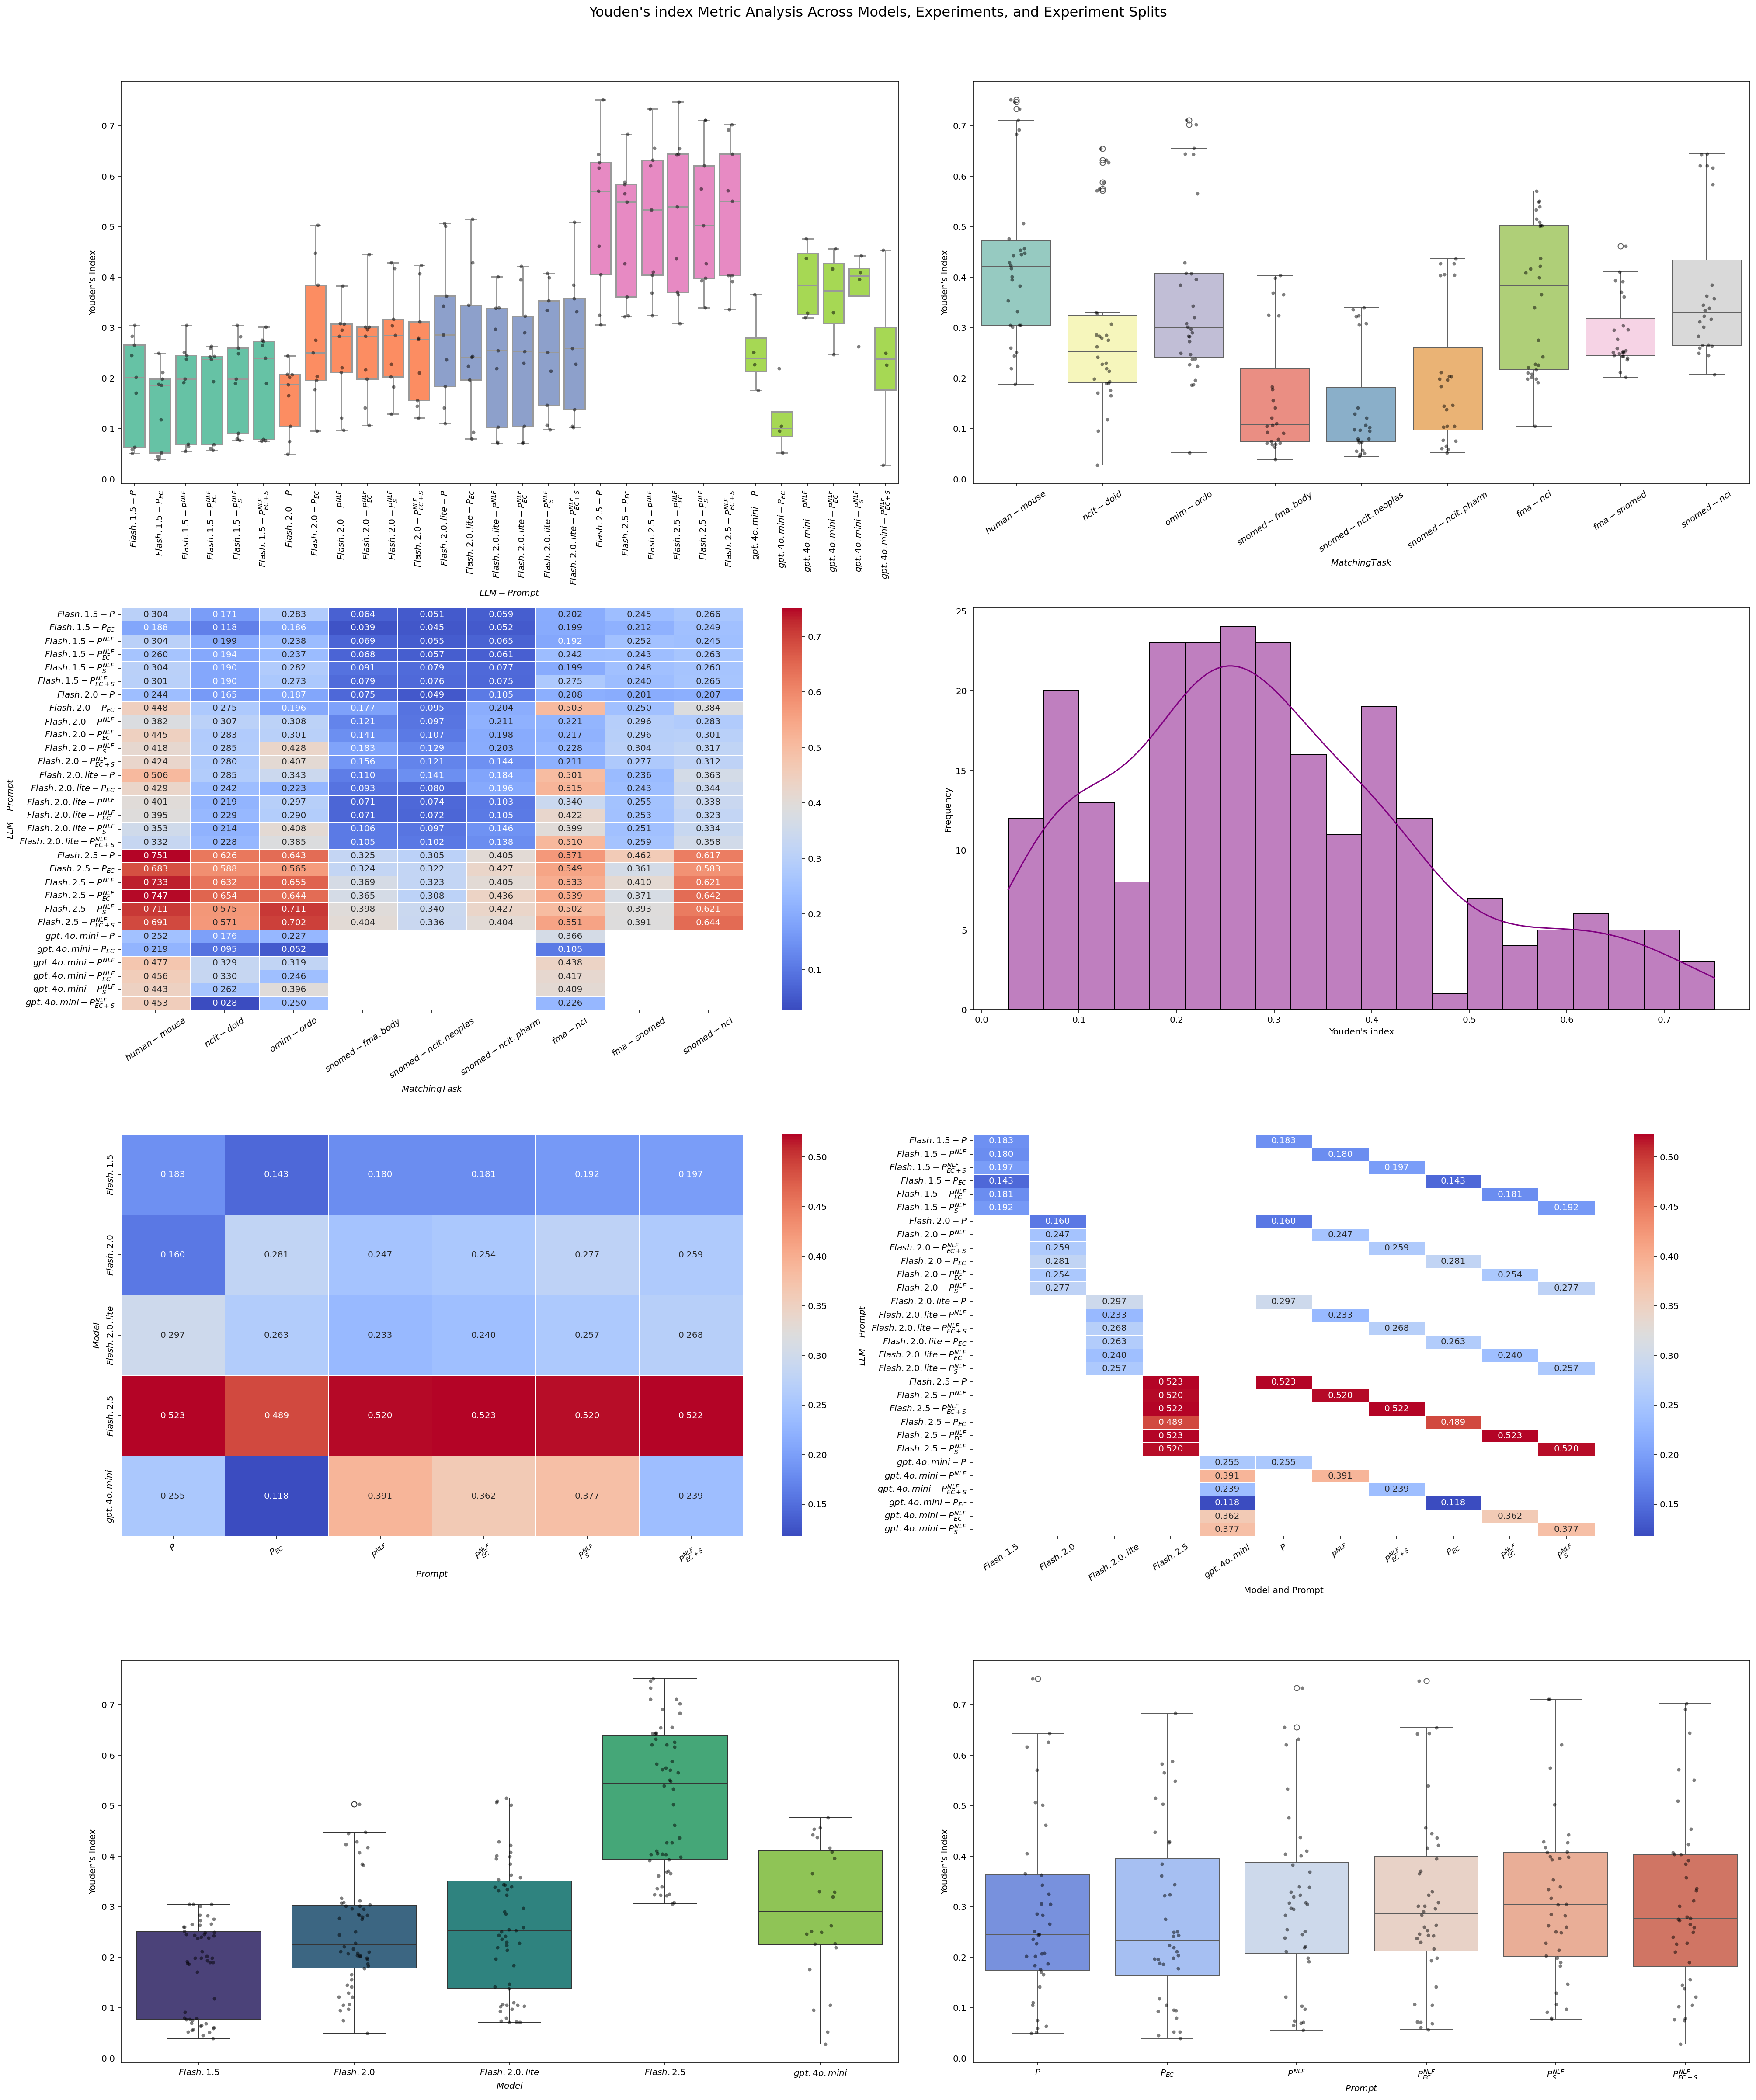

In [75]:
experiment_col, left_col, right_col = "Matching Task", "Model", "Prompt"

for suffix in ["", "_reduced"]:
    for metric in ["Youden's index", "F1 Score"]:
        metrics_df = preprocess_metrics_df(pd.read_csv(RUN_DIR / f"all_runs_metrics{suffix}.csv"))
        plot_detaild_analysis(
            metrics_df=metrics_df,
            metric=metric,
            run_col_name="LLM-Prompt",
            experiment_col=experiment_col,
            left_col=left_col,
            right_col=right_col,
            left_col_name="Model",
            right_col_name="Prompt",
            run_separator="-",
            precision=3,
            subfolder_name=f"{metric}{suffix}",
            save_plots=False,
)
        plt.show()

## Copy best results

In [ ]:
prompt_type = "direct_entity_with_synonyms---"
model = "gemini-2.5-flash-preview-04-17"

In [ ]:
for run_metadata in RUNS_METADATA:
    run_name, model_name, subset_name, experiment_name = run_metadata
    run_dir = Path("runs") / run_name
    for file in run_dir.iterdir():
        if prompt_type in str(file) and model in str(file) and str(file).endswith(".csv"):
            logging.info(f"Processing {file} in {file}")
            new_file_path = OUTPUTS_DIR / "best_results" / datetime.now().strftime("%Y-%m-%d") / file.name
            new_file_path.parent.mkdir(parents=True, exist_ok=True)
            shutil.copy(file, new_file_path)

## Gather outputs inference

In [79]:
outputs_dir = Path("./outputs")
datasets_map = {"anatomy": ["human-mouse"], "largebio": ["fma-nci"], "bioml-2024": ["omim-ordo"]}
models = ["gemini-2.0-flash-lite", "gemini-2.0-flash"]
experiments_subtypes = {"syspromts" : ["none", "base", "natural_language", "ontology_aware", "synonym_aware"]}
# experiments_subtypes = {"determinism" : ["0", "1", "2", "3"]}

dfs = []

for dataset, subsets_map in datasets_map.items():
    for set_name in subsets_map:
        for model in models:
            for experiment_type in experiments_subtypes:
                for experiment in experiments_subtypes[experiment_type]:
                    run_subdir = f"{dataset}/{set_name}/{model}/{experiment_type}/{experiment}"
                    metrics_df = pd.read_csv(outputs_dir / run_subdir / "results.csv")

                    for col, value in zip(["Dataset", "SubSet", "Model", "ExperimentType", "ExpName"
                                           ], [dataset, set_name, model, experiment_type, experiment]):
                        if col not in metrics_df.columns:
                            metrics_df[col] = value

                    metrics_df["Run"] = run_subdir
                    dfs.append(metrics_df)

results_df = pd.concat(dfs, ignore_index=True)
results_df = preprocess_metrics_df(results_df)

In [80]:
results_df.head(7)

,Prompt,Accuracy,Precision,Recall,F1 Score,Specificity,Sensitivity,Dataset,Matching Task,Model,ExperimentType,ExpName,Run,Youden's index
31,P,0.8040,0.8664,0.8664,0.8664,0.6321,0.8664,anatomy,human-mouse,Flash.2.0,syspromts,none,anatomy/human-mouse/gemini-2.0-flash/syspromts...,0.4985
37,P,0.7714,0.8792,0.7979,0.8366,0.6981,0.7979,anatomy,human-mouse,Flash.2.0,syspromts,base,anatomy/human-mouse/gemini-2.0-flash/syspromts...,0.4960
43,P,0.7940,0.7853,0.9897,0.8758,0.2547,0.9897,anatomy,human-mouse,Flash.2.0,syspromts,natural_language,anatomy/human-mouse/gemini-2.0-flash/syspromts...,0.2444
49,P,0.8492,0.8718,0.9315,0.9007,0.6226,0.9315,anatomy,human-mouse,Flash.2.0,syspromts,ontology_aware,anatomy/human-mouse/gemini-2.0-flash/syspromts...,0.5541
55,P,0.8191,0.8526,0.9110,0.8808,0.5660,0.9110,anatomy,human-mouse,Flash.2.0,syspromts,synonym_aware,anatomy/human-mouse/gemini-2.0-flash/syspromts...,0.4770
33,P_{EC},0.8367,0.8328,0.9726,0.8973,0.4623,0.9726,anatomy,human-mouse,Flash.2.0,syspromts,none,anatomy/human-mouse/gemini-2.0-flash/syspromts...,0.4349
39,P_{EC},0.8116,0.8444,0.9110,0.8764,0.5377,0.9110,anatomy,human-mouse,Flash.2.0,syspromts,base,anatomy/human-mouse/gemini-2.0-flash/syspromts...,0.4487


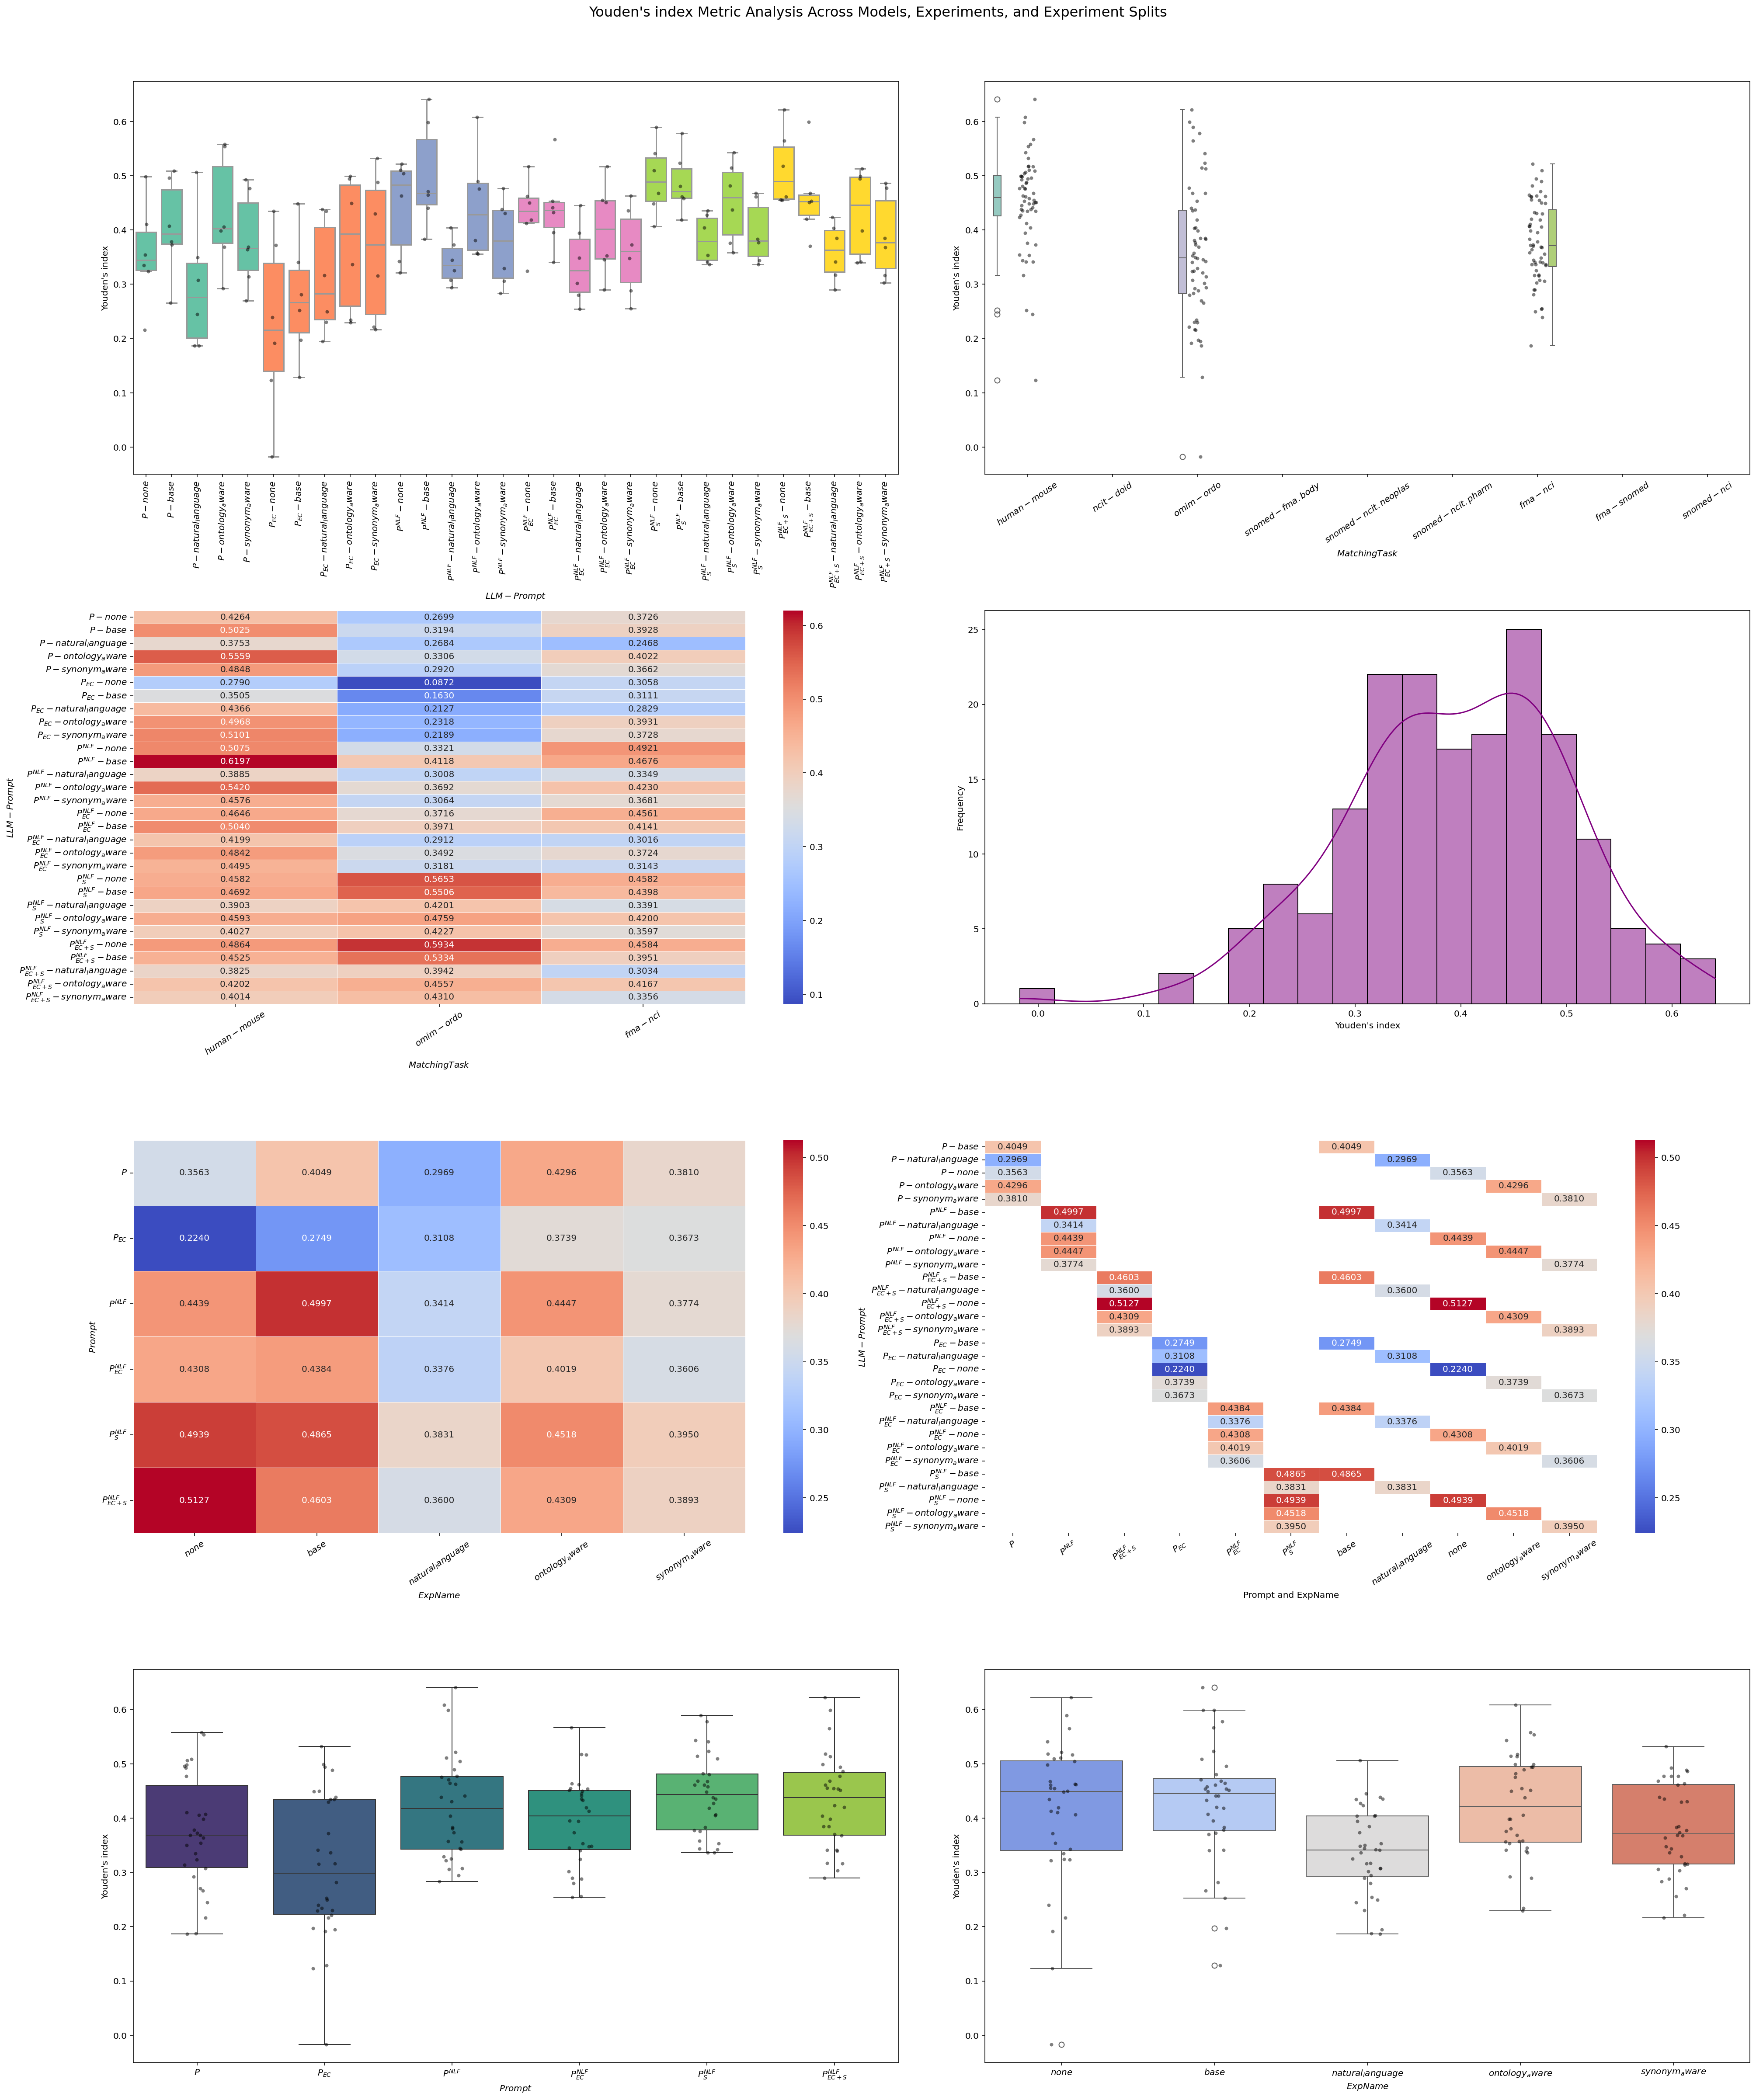

In [ ]:
metrics_df = results_df.copy()
metric = "Youden's index"

experiment_col, left_col, right_col = "Matching Task", "Prompt", "ExpName"

for metric in ["Youden's index", "F1 Score"]:
    plot_detaild_analysis(
        metrics_df=metrics_df,
        metric=metric,
        run_col_name="LLM-Prompt",
        experiment_col=experiment_col,
        left_col=left_col,
        right_col=right_col,
        left_col_name=left_col,
        right_col_name=right_col,
        run_separator="-",
        precision=4,
        subfolder_name=f"{next(iter(experiments_subtypes.keys()))}/{metric}",
        save_plots=False,
    )
    plt.show()

## Radar Charts

In [83]:
def make_radar_chart(
    ax: plt.Axes,
    categories: list[str],
    values_list: list[list[float]],
    labels: list[str],
    colors: list[str],
    linestyles: list[str],
    r_range: tuple[float, float],
    title: str,
    scale: float = 1.01,
) -> None:
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)

    ax.set_rlabel_position(0)
    ax.set_ylim(*r_range)
    yticks = np.linspace(r_range[0], r_range[1], 4)
    ax.set_yticks(yticks)
    ax.set_yticklabels([f"{y:.3f}" for y in yticks], fontsize=9)

    for values, label, color, linestyle in zip(values_list, labels, colors, linestyles):
        values += values[:1]
        ax.set_ylim(ax.get_ylim()[0], np.max(values) * scale)
        ax.plot(angles, values, label=label, color=color, linestyle=linestyle, linewidth=1)
        ax.fill(angles, values, color=color, alpha=0.05)
        ax.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.5)

    ax.set_title(title, size=12, y=1.1)
    plt.tight_layout(rect=[0, 0.08, 1, 0.93])

In [84]:
f1_oracle_df = pd.read_csv(METRICS_DIR / "OASystem_with_oracle_f1.csv", sep='\t')
f1_oracle_df = f1_oracle_df[
    [
        "Task",
        '$OASystem(auto)$',
        # '$OASystem+Or^{GF2.0}$',
        '$OASystem+Or^{0}$',
        # '$OASystem+Or^{10}$',
        '$OASystem+Or^{20}$',
        '$OASystem+Or^{30}$',
        '$OASystem+Or^{LLM}$',
    ]
]
labels = f1_oracle_df.columns[1:]
f1_oracle_df

,Task,$OASystem(auto)$,$OASystem+Or^{0}$,$OASystem+Or^{20}$,$OASystem+Or^{30}$,$OASystem+Or^{LLM}$
0,Mouse-Human,0.880,0.910,0.891,0.884,0.898
1,NCIT-DOID,0.869,0.916,0.898,0.888,0.895
2,FMA-NCI,0.829,0.875,0.840,0.830,0.828
3,SNOMED-NCI,0.743,0.766,0.749,0.740,0.751
4,OMIM-ORDO,0.592,0.632,0.616,0.612,0.626
5,SNOMED-FMA.body,0.607,0.643,0.631,0.628,0.632
6,SNOMED-NCIT.neoplas,0.691,0.740,0.706,0.690,0.701
7,SNOMED-NCIT.pharm,0.711,0.732,0.721,0.714,0.719
8,FMA-SNOMED,0.710,0.747,0.721,0.706,0.694


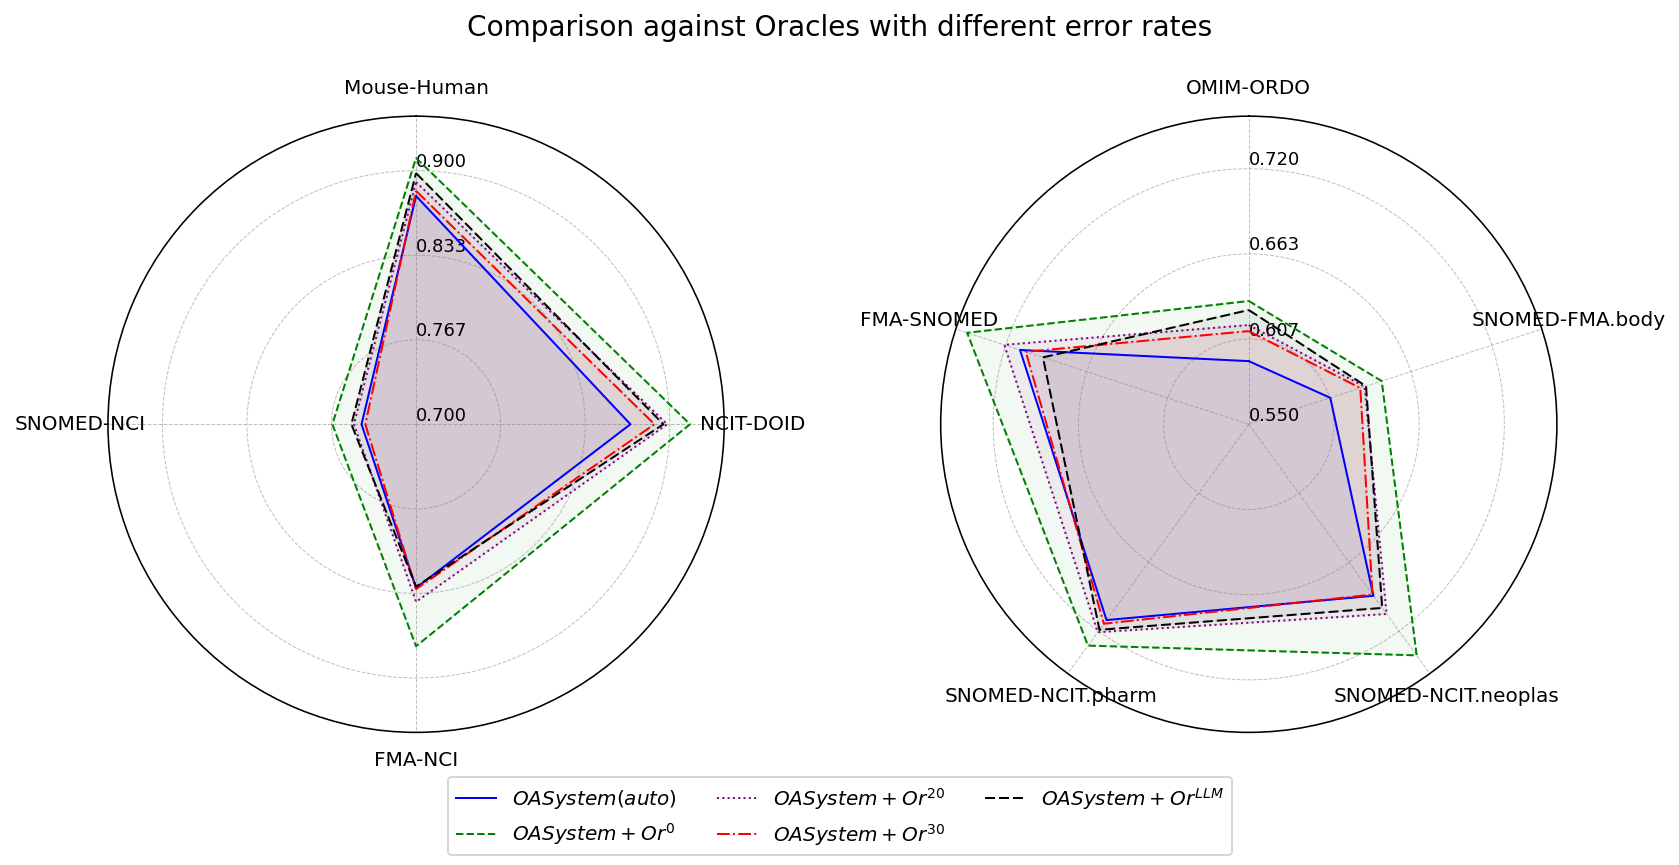

In [85]:
idx = 4
oracle_df = f1_oracle_df.copy()

categories1, categories2 = oracle_df["Task"].tolist()[:idx], oracle_df["Task"].tolist()[idx:]
values_list1 = oracle_df.iloc[:, 1:].to_numpy()[:idx].T.tolist()
values_list2 = oracle_df.iloc[:, 1:].to_numpy()[idx:].T.tolist()

colors = ["blue", "green", "purple", "red", "black"]
linestyles = ["solid", "dashed", "dotted", "dashdot", (0, (5, 2))]

fig, axs = plt.subplots(1, 2, subplot_kw={"polar": True}, figsize=(12, 6))
make_radar_chart(axs[0], categories1, values_list1, labels, colors, linestyles, (0.7, 0.9), "", scale=1.05)
make_radar_chart(axs[1], categories2, values_list2, labels, colors, linestyles, (0.55, 0.72), "", scale=1.05)

handles, _ = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, fontsize=10)

fig.suptitle("Comparison against Oracles with different error rates", fontsize=14)

save_path = METRICS_DIR / datetime.today().strftime("%Y-%m-%d") / "OASystem" / "OA_with_oracle_radar_chart.png"
# save_path.parent.mkdir(parents=True, exist_ok=True)
# fig.savefig(save_path, bbox_inches="tight")

In [86]:
exp_oracle_df = pd.read_csv(METRICS_DIR / "OASystem_with_oracle_f1.csv", sep="\t")

for col in exp_oracle_df.columns[:0:-1]:
    exp_oracle_df[col] -= exp_oracle_df.iloc[:, 1]
exp_oracle_df

,Task,$OASystem(auto)$,$OASystem+Or^{LLM}$,$OASystem+Or^{LLM}GF2.0$,$OASystem+Or^{0}$,$OASystem+Or^{10}$,$OASystem+Or^{20}$,$OASystem+Or^{30}$
0,Mouse-Human,0.0,0.018,0.012,0.030,0.021,0.011,0.004
1,NCIT-DOID,0.0,0.026,0.013,0.047,0.038,0.029,0.019
2,FMA-NCI,0.0,-0.001,0.016,0.046,0.030,0.011,0.001
3,SNOMED-NCI,0.0,0.008,0.004,0.023,0.014,0.006,-0.003
4,OMIM-ORDO,0.0,0.034,0.028,0.040,0.033,0.024,0.020
5,SNOMED-FMA.body,0.0,0.025,0.015,0.036,0.030,0.024,0.021
6,SNOMED-NCIT.neoplas,0.0,0.010,0.003,0.049,0.032,0.015,-0.001
7,SNOMED-NCIT.pharm,0.0,0.008,0.008,0.021,0.016,0.010,0.003
8,FMA-SNOMED,0.0,-0.016,0.009,0.037,0.026,0.011,-0.004


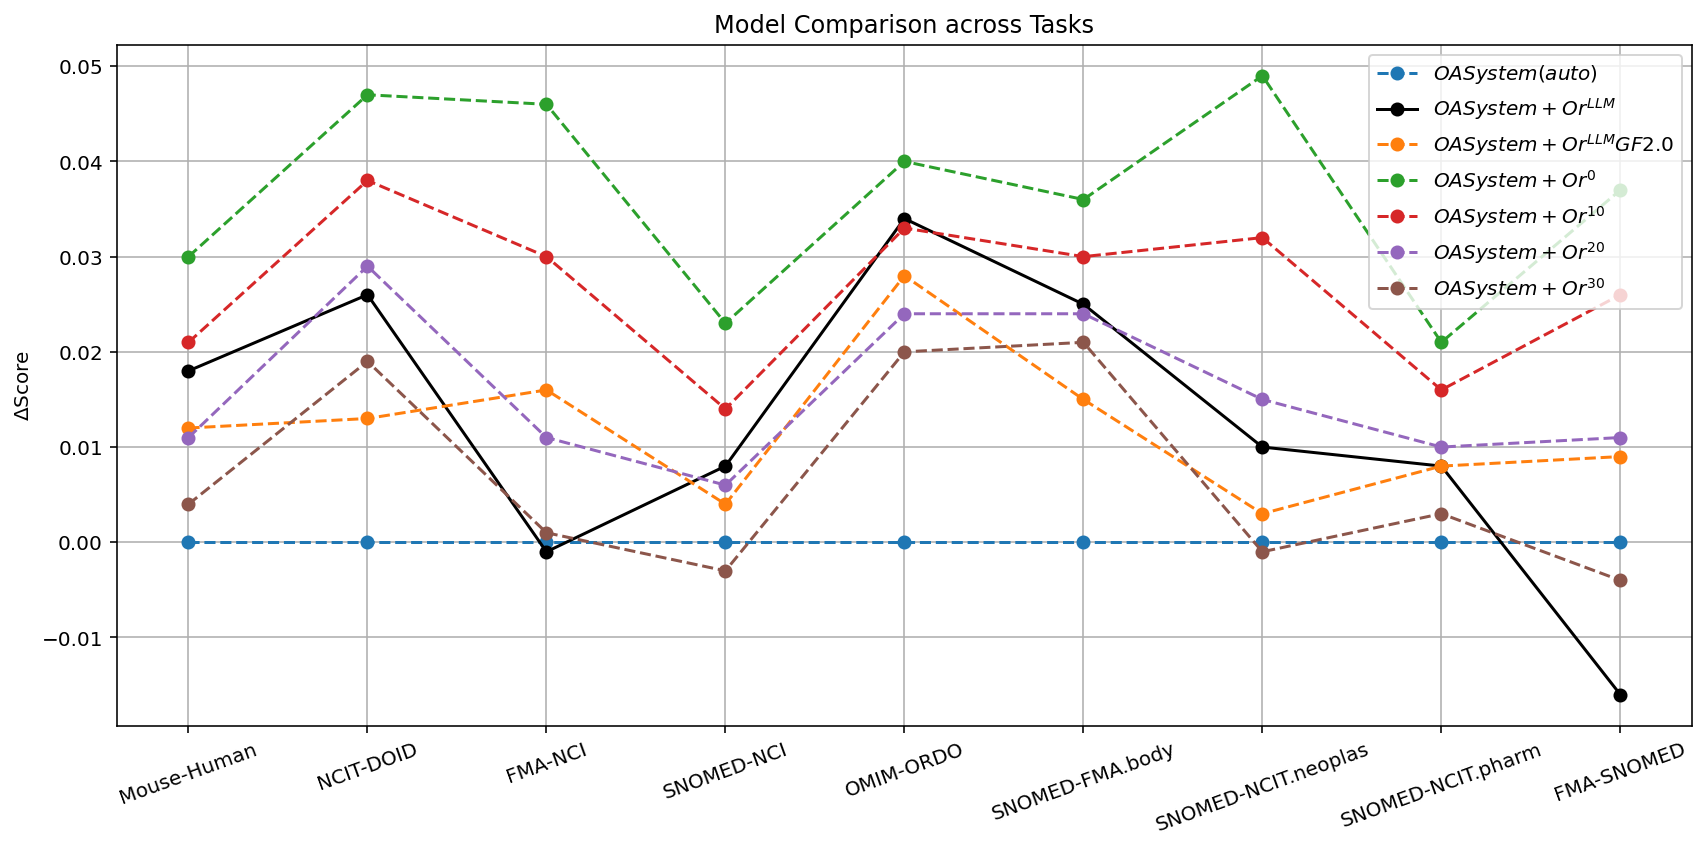

In [ ]:
plt.figure(figsize=(12, 6))

for col in exp_oracle_df.columns[1:]:
    if "LLM}$" in col:
        plt.plot(exp_oracle_df["Task"], exp_oracle_df[col], label=col, color="black", marker="o")
    else:
        plt.plot(exp_oracle_df["Task"], exp_oracle_df[col], label=col, linestyle="--", marker="o")

plt.xticks(rotation=20, ha="center")
plt.ylabel(r"$\Delta$Score")
plt.title("Model Comparison across Tasks")
plt.legend()
plt.grid(True)
plt.tight_layout()

save_path = METRICS_DIR / datetime.today().strftime("%Y-%m-%d") / "OASystem" / "OA_with_oracle_line_chart.png"
# save_path.parent.mkdir(parents=True, exist_ok=True)
# plt.savefig(save_path, bbox_inches="tight")